In [93]:
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
from scipy.optimize import linear_sum_assignment
import cv2
from torch.utils.data import DataLoader
from tracktor.datasets.factory import Datasets
from tracktor.config import get_output_dir
from torchvision.ops.boxes import clip_boxes_to_image, nms
import pandas as pd
import numba
from numba import int16, jit, int32
import numpy as np
import time


In [46]:
dataset_name="mot17_train_FRCNN17"
dataset = Datasets(dataset_name)
seq = dataset[0]
data_loader = DataLoader(seq, batch_size=1, shuffle=False)

In [136]:

@jit(int16[:,:,:,:](int16[:,:,:,:],int16[:,:,:,:]))
def go_fast(img_np,all_histograms): # Function is compiled and runs in machine code
    height=img_np.shape[2]
    width=img_np.shape[3]
    n=img_np.shape[0]
    for x in range(width):
        for y in range(height):
            for c in range(3):
                for i in range(int(n)):
                    val = img_np[i,c,y,x]                    
                    all_histograms[val,c,y,x]+=1
    return all_histograms

all_histograms= None
start = time.time()
watch_point= start
color_scale_factor=4
frame_interval=20

for i, frame in enumerate(data_loader):    
    if i%frame_interval==0:
        img= frame['img']
        height=img.shape[2]
        width=img.shape[3]
        if all_histograms is None:
            all_histograms=np.zeros((256//color_scale_factor,3,height,width),dtype=np.int16)
            average_imaged=np.zeros((3,height,width),dtype=np.int16)
        img=((256//color_scale_factor-1)*img)
        img=img.type(torch.uint8)
        img_np=img.numpy().astype(np.int16)
        rel_mark_1= time.time()
        average_imaged+=img_np[0]
        all_histograms=go_fast( img_np,all_histograms)
        current = time.time()
        print(f"Current = {(current-start):.2f} rel_mark_1 = {(rel_mark_1-watch_point):.2f} rel_mark_2 = {(current-watch_point):.2f}" )
        watch_point=current
end = time.time()
print("Elapsed = %s" % (end - start))

Current = 0.61 rel_mark_1 = 0.06 rel_mark_2 = 0.61
Current = 1.92 rel_mark_1 = 0.96 rel_mark_2 = 1.31
Current = 3.22 rel_mark_1 = 0.94 rel_mark_2 = 1.30
Current = 4.61 rel_mark_1 = 1.04 rel_mark_2 = 1.39
Current = 5.92 rel_mark_1 = 0.96 rel_mark_2 = 1.31
Current = 7.22 rel_mark_1 = 0.95 rel_mark_2 = 1.30
Current = 8.55 rel_mark_1 = 0.98 rel_mark_2 = 1.33
Current = 9.90 rel_mark_1 = 1.00 rel_mark_2 = 1.35
Current = 11.22 rel_mark_1 = 0.96 rel_mark_2 = 1.31
Current = 12.53 rel_mark_1 = 0.96 rel_mark_2 = 1.31
Current = 13.81 rel_mark_1 = 0.94 rel_mark_2 = 1.28
Current = 15.12 rel_mark_1 = 0.97 rel_mark_2 = 1.31
Current = 16.40 rel_mark_1 = 0.92 rel_mark_2 = 1.28
Current = 17.70 rel_mark_1 = 0.94 rel_mark_2 = 1.29
Current = 19.03 rel_mark_1 = 0.98 rel_mark_2 = 1.33
Current = 20.48 rel_mark_1 = 1.05 rel_mark_2 = 1.46
Current = 21.93 rel_mark_1 = 0.96 rel_mark_2 = 1.45
Current = 23.51 rel_mark_1 = 1.11 rel_mark_2 = 1.58
Current = 25.16 rel_mark_1 = 1.19 rel_mark_2 = 1.65
Current = 26.54 rel_

In [48]:
@jit(int16[:,:,:,:](int16[:,:,:,:],int32))
def find_bg(all_histograms, color_scale_factor): # Function is compiled and runs in machine code
    height=img_np.shape[2]
    width=img_np.shape[3]
    n=img_np.shape[0]
    bg=np.zeros((2,3,height,width),dtype=np.int16)
    for x in range(width):
        for y in range(height):
            for c in range(3):
                arg=np.argmax(all_histograms[:,c,y,x])    
                bg[0,c,y,x]= color_scale_factor * arg
                bg[1,c,y,x]= all_histograms[arg,c,y,x]
    return bg

In [49]:
bg= find_bg(all_histograms,color_scale_factor)

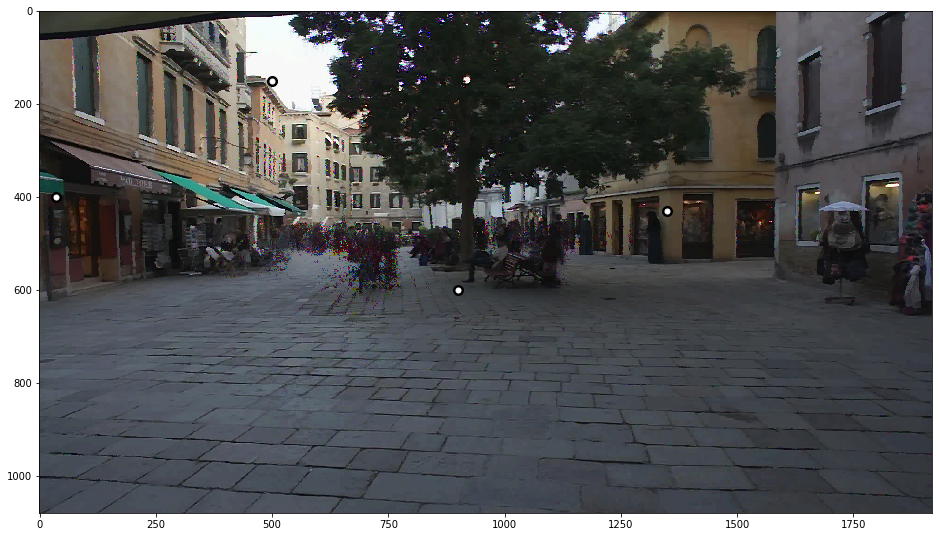

In [50]:
im2show=np.swapaxes(np.swapaxes(bg[0], 0, 2),1,0)
plt.figure(figsize = (16,12))
plt.imshow(im2show)
# plt.axis('off')

for p in points:
    x=p[0]
    y=p[1]
    plt.scatter(x,y,s=100,c='k')
    plt.scatter(x,y,s=25,c='w')
plt.show()

In [51]:
points= [[500,150],[900,600],[35,400],[1350,430]]

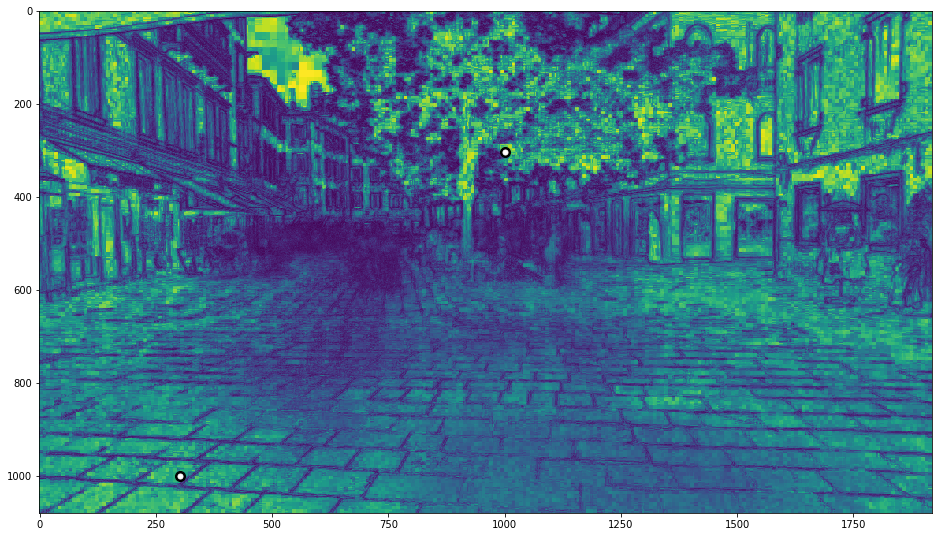

In [127]:
hm2show=8*np.swapaxes(np.swapaxes(bg[1], 0, 2),1,0)
plt.figure(figsize = (16,12))
hm2show_grey=np.sum(hm2show,axis=2)
plt.imshow(hm2show_grey)
for p in points:
    x=p[0]
    y=p[1]
    plt.scatter(x,y,s=100,c='k')
    plt.scatter(x,y,s=25,c='w')
plt.show()

<Figure size 1080x360 with 0 Axes>

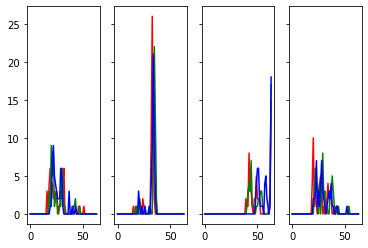

In [45]:
plt.figure(figsize = (15,5))
f, axs = plt.subplots(1, len(points), sharey=True)

for i, p in enumerate(points):
    x=p[0]
    y=p[1]
    ax=axs[i]
    ax.plot(all_histograms[:,0,y,x],c='r')
    ax.plot(all_histograms[:,1,y,x],c='g')
    ax.plot(all_histograms[:,2,y,x],c='b')
plt.show()


(1080, 1920)


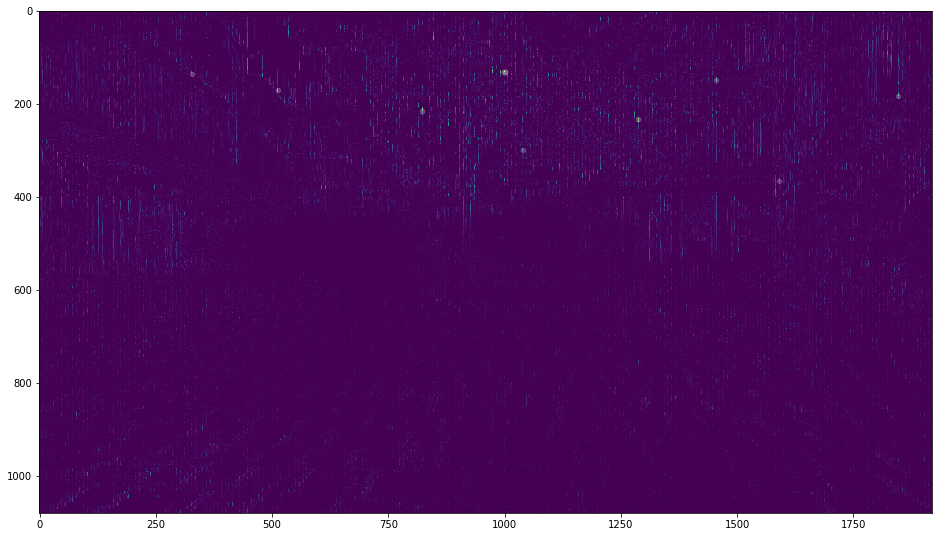

In [124]:
axis=1
grid=200
n_best=10
hm= np.sum(bg[1],axis=0)
print(hm.shape)
hm2show=np.gradient(hm, axis=axis)**2
grid_points=[]
for x_grid in range(0,width,grid):
    for y_grid in range(0,height,grid):
            subset= hm2show[y_grid:y_grid+grid, x_grid:x_grid+grid]
            amax= np.unravel_index(np.argmax(subset),subset.shape)
            max= subset[amax]
            grid_points.append([amax[0]+y_grid,amax[1]+x_grid,max] )
grid_points=np.array(grid_points)
df = pd.DataFrame(grid_points)
df = df.sort_values(by=[2], ascending=False)
grid_points = df.iloc[:n_best].to_numpy()
plt.figure(figsize = (16,12))
plt.imshow(hm2show)
for p in grid_points:
    x=p[1]
    y=p[0]
    plt.scatter(x,y,s=p[2]/50,c='w',alpha=0.2)
plt.show()

[ 7 21 21  6 31 52 48 17  9 31 38 23 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 24 24 24 24 24 24 24 24 24 25 25 25 25]
[16 14 26 44 60 41 19  9 14 25 31 33 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 25 25 25 25 25 25 25 25 24 24 24 24]
[21 31 43 52 52 44 32 21 16 17 22 27 23 21 20 18 17 15 14 13 23 23 23 23
 23 23 23 23 24 24 24 24 24 24 24 24 25 25 25 25]
[16  1 24 67 81 56 28 16 22 30 30 25 25 25 25 25 25 25 25 25 24 23 23 23
 23 23 23 23 23 23 23 23 23 23 23 23 25 25 25 25]
[20 41 70 89 25 24 25 24 25 24 25 24 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25]
[17 19 25 29 77 44 11  5 23 37 32 20 25 24 25 24 25 24 25 24 25 24 25 24
 25 24 25 24 25 25 25 25 25 25 25 25 25 25 25 25]
[23 16 25 46 55 40 24 18 23 30 31 27 26 25 25 25 25 25 25 25 24 24 24 24
 24 24 24 24 24 24 24 24 24 24 24 24 25 25 25 25]
[ 9 10 10  7 64 97 63 14 25 33 17 17 24 24 24 24 24 24 24 24 36 34 31 26
 22 17 14 12 25 25 25 25 25 25 25 25 22 22 22 22]
[15 51 81 90 23 

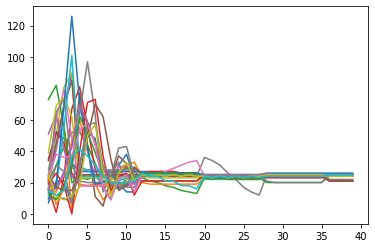

In [123]:
for i, frame in enumerate(data_loader):    
    if i%frame_interval==0:
        img= frame['img']
        height=img.shape[2]
        width=img.shape[3]
#         print(img.shape)
        img=((256-1)*img)
        img=img.type(torch.uint8)
        img_np=img.numpy().astype(np.int16)
#         print(img_np.shape)
        img_np=np.sum(img_np,axis=1)//3
        
#         print(img_np.shape)
        img_np=img_np.reshape(height,width)
#         print(img_np.shape)
        
        gp_idx=0
        grid_point=np.asarray(grid_points[gp_idx],dtype=np.int)
#         print(grid_point)
        length=40
        if axis==1:
            series=img_np[grid_point[0]-length//2:grid_point[0]+length//2,grid_point[1]]
        elif axis==0:
            series=img_np[grid_point[0],grid_point[1]-length//2:grid_point[1]+length//2]
        print (series)    
        plt.plot(series)
plt.show()

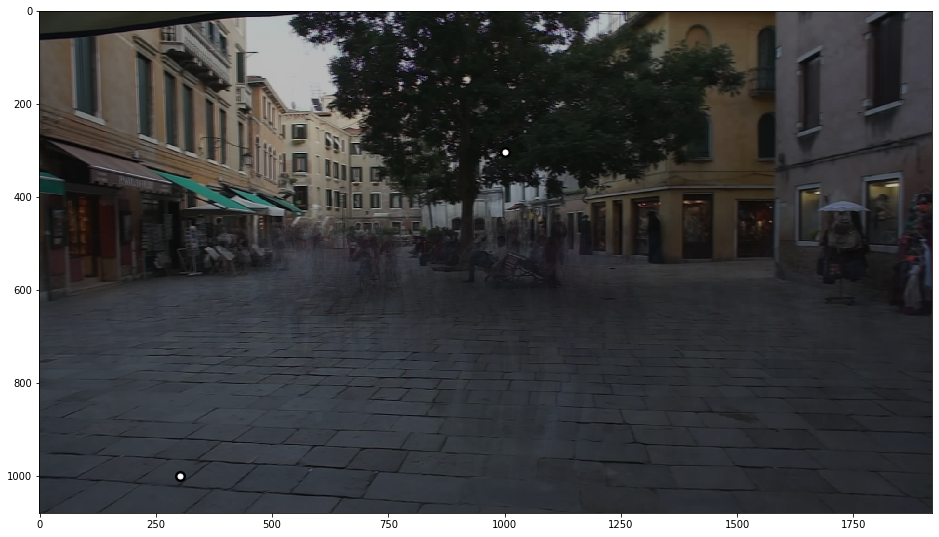

In [145]:
average_imaged2show=np.swapaxes(np.swapaxes(average_imaged, 0, 2),1,0)//10
plt.figure(figsize = (16,12))
plt.imshow(average_imaged2show)
for p in points:
    x=p[0]
    y=p[1]
    plt.scatter(x,y,s=100,c='k')
    plt.scatter(x,y,s=25,c='w')
plt.show()



In [158]:
from scipy.ndimage import convolve1d

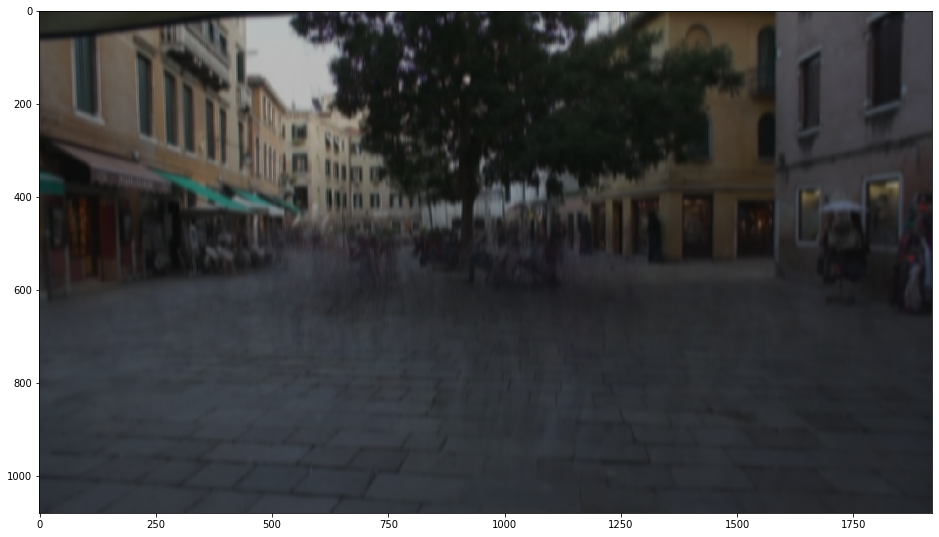

In [194]:
sigma=5
axis=1
grid=200
n_best=10

x=np.arange(-sigma*3,sigma*3)
weights=(1/(np.sqrt(2*np.pi)*sigma)*np.exp(-0.5*((x/sigma)**2)))
other_axis= [1,0][axis]
filtered_image=convolve1d(average_imaged, weights, axis=other_axis+1 )

plt.figure(figsize = (16,12))
plt.imshow(np.swapaxes(np.swapaxes(filtered_image//10, 0, 2),1,0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1080, 1920)
[  0.  646.  855.5]
[219. 491. 775.]
[ 384. 1014.  754.]
[  14.  1256.   735.5]
[282.  631.  719.5]
[133.  427.  716.5]
[150.  926.  702.5]
[ 400.  1014.   672.5]
[427.  910.  650.5]
[337.  946.  650.5]


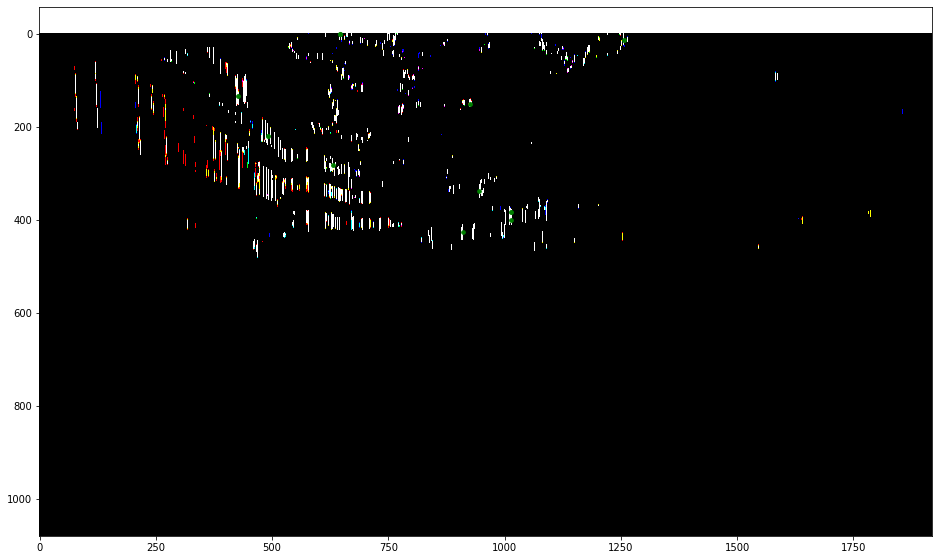

In [299]:
grad_image=np.abs(np.gradient(filtered_image, axis=axis+1))
grad_image2show=np.swapaxes(np.swapaxes(grad_image, 0, 2),1,0)//100
grid_points=[]
print(grad_image.shape)
for x_grid in range(0,width,grid):
    for y_grid in range(0,height,grid):
            subset= np.sum(grad_image[:,y_grid:y_grid+grid, x_grid:x_grid+grid],axis=0)
            amax= np.unravel_index(np.argmax(subset),subset.shape)
            max= subset[amax]
            grid_points.append([amax[0]+y_grid,amax[1]+x_grid,max] )
grid_points=np.array(grid_points)
df = pd.DataFrame(grid_points)
df = df.sort_values(by=[2], ascending=False)
grid_points = df.iloc[:n_best].to_numpy()
plt.figure(figsize = (16,12))
plt.imshow(grad_image2show)
for p in grid_points:
    print(p)
    x=p[1]
    y=p[0]
    plt.scatter(x,y,s=p[2]/50,c='g')
plt.show()

In [210]:
gp_idx


0

0.997294665511095

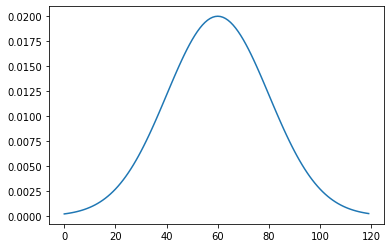

In [181]:
plt.plot(weights)
np.sum(weights)

In [295]:
length=40
frame_interval=20
num_frames=len(data_loader)//frame_interval
series=np.zeros((num_frames,len(grid_points),2,3,length))
for i, frame in enumerate(data_loader):    
    if i%frame_interval==0:
        img= frame['img']
        height=img.shape[2]
        width=img.shape[3]
        img=((256-1)*img)
        img=img.type(torch.uint8)
        img_np=img.numpy().astype(np.int16)
        img_np=img_np.reshape(3,height,width)
        if i==0:
            first_image=img_np
        for gp_idx in range(len(grid_points)):
            grid_point=np.asarray(grid_points[gp_idx],dtype=np.int)
            if axis==0:
                series[i//frame_interval,gp_idx,axis,:,:]=img_np[:,grid_point[0]-length//2:grid_point[0]+length//2,grid_point[1]].reshape(3,length)
            elif axis==1:
                series[i//frame_interval,gp_idx,axis,:,:]=img_np[:,grid_point[0],grid_point[1]-length//2:grid_point[1]+length//2].reshape(3,length)

In [296]:

ref_image= average_imaged
ref_image= first_image

ref_series=np.zeros((len(grid_points),2,3,length))



for gp_idx in range(len(grid_points)):
    
    grid_point=np.asarray(grid_points[gp_idx],dtype=np.int)
    if axis==0:
        ref_series[gp_idx,axis,:,:]=ref_image[:,grid_point[0]-length//2:grid_point[0]+length//2,grid_point[1]].reshape(3,length)
    elif axis==1:
        ref_series[gp_idx,axis,:,:]=ref_image[:,grid_point[0],grid_point[1]-length//2:grid_point[1]+length//2].reshape(3,length)


In [281]:
from scipy.signal import correlate


In [282]:
series.shape

(30, 10, 2, 3, 40)

In [283]:
len(data_loader)

600

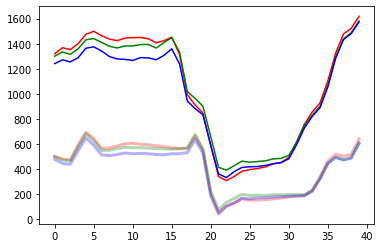

In [284]:
gp_idx=5

plt.plot(ref_series[gp_idx,axis,0],c='r')
plt.plot(ref_series[gp_idx,axis,1],c='g')
plt.plot(ref_series[gp_idx,axis,2],c='b')
frame_id=1
lw=3
alpha=0.3
plt.plot(3*series[frame_id,gp_idx,axis,0],c='r', lw=lw, alpha=alpha)
plt.plot(3*series[frame_id,gp_idx,axis,1],c='g', lw=lw, alpha=alpha)
plt.plot(3*series[frame_id,gp_idx,axis,2],c='b', lw=lw, alpha=alpha)

plt.show()



In [297]:
corss_corr=np.zeros

cross_corr=np.zeros((num_frames,len(grid_points),2,3,length*2-1))
for gp_idx in range(len (grid_points)):
    for frame_id in range(num_frames):
        for c in range(3):           
            a=correlate(ref_series[gp_idx,axis,c,:],series[frame_id,gp_idx,axis,c,:] )
            cross_corr[frame_id,gp_idx,axis,c]= a
            


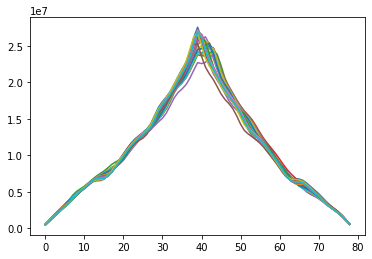

array([39, 40, 40, 40, 41, 39, 39, 39, 41, 42, 42, 42, 43, 43, 43, 42, 42,
       43, 42, 42, 42, 40, 40, 39, 39, 39, 39, 39, 39, 39], dtype=int64)

In [298]:
frame_id=1
gp_idx=2
axis=1
c=2
positions=[]
for frame_id in range(num_frames):
    all_corr=np.sum(cross_corr[frame_id,:,axis,:],axis=(0,1))
    plt.plot(all_corr)
    positions.append(np.argmax(all_corr))
plt.show()
np.array(positions)

In [287]:
cross_corr_all.shape

(30, 79)

In [270]:
cross_corr[frame_id,gp_idx,axis,:].shape

(3, 79)